# NER - From text to recipe
After the app was packed with OCR funcion, I need a solution to extract recipes from text. After some research I've decided to use NER - Named Entity Recongition with Tensorflow





## Dataset
The dataset used is the TASTEset

In [1]:
!git clone https://github.com/taisti/TASTEset

Cloning into 'TASTEset'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 41 (delta 8), reused 3 (delta 3), pack-reused 29
Receiving objects: 100% (41/41), 209.16 KiB | 1.39 MiB/s, done.
Resolving deltas: 100% (14/14), done.


## Analyzing the data

In [2]:
import pandas as pd
data_path = "TASTEset/data/TASTEset.csv"
data = pd.read_csv(data_path, encoding='utf8')

In [3]:
data.head()

,ingredients,ingredients_entities
0,5 ounces rum\n4 ounces triple sec\n3 ounces Ti...,"[{""start"": 0, ""end"": 1, ""type"": ""QUANTITY"", ""e..."
1,"2 tubes cinnamon roll, refrigerated, with icin...","[{""start"": 0, ""end"": 1, ""type"": ""QUANTITY"", ""e..."
2,4 ripe coconuts\n1 cup evaporated milk\n1 cup ...,"[{""start"": 0, ""end"": 1, ""type"": ""QUANTITY"", ""e..."
3,1 sheet graham cracker (broken in half)\n2 pie...,"[{""start"": 0, ""end"": 1, ""type"": ""QUANTITY"", ""e..."
4,1 (8 ounce) package crescent rolls\n8 slices d...,"[{""start"": 0, ""end"": 1, ""type"": ""QUANTITY"", ""e..."


In [4]:
data["ingredients_entities"][0]

'[{"start": 0, "end": 1, "type": "QUANTITY", "entity": "5"},{"start": 2, "end": 8, "type": "UNIT", "entity": "ounces"},{"start": 9, "end": 12, "type": "FOOD", "entity": "rum"},{"start": 13, "end": 14, "type": "QUANTITY", "entity": "4"},{"start": 15, "end": 21, "type": "UNIT", "entity": "ounces"},{"start": 22, "end": 32, "type": "FOOD", "entity": "triple sec"},{"start": 33, "end": 34, "type": "QUANTITY", "entity": "3"},{"start": 35, "end": 41, "type": "UNIT", "entity": "ounces"},{"start": 42, "end": 51, "type": "FOOD", "entity": "Tia Maria"},{"start": 52, "end": 54, "type": "QUANTITY", "entity": "20"},{"start": 55, "end": 61, "type": "UNIT", "entity": "ounces"},{"start": 62, "end": 74, "type": "FOOD", "entity": "orange juice"}]'

The labels are formatted in JSON where each entity holds its position inside the ingredient sentence

In [5]:
 import json
 ingredients_entities = json.loads(data.at[0, "ingredients_entities"])

In [6]:
ingredients_entities

[{'start': 0, 'end': 1, 'type': 'QUANTITY', 'entity': '5'},
 {'start': 2, 'end': 8, 'type': 'UNIT', 'entity': 'ounces'},
 {'start': 9, 'end': 12, 'type': 'FOOD', 'entity': 'rum'},
 {'start': 13, 'end': 14, 'type': 'QUANTITY', 'entity': '4'},
 {'start': 15, 'end': 21, 'type': 'UNIT', 'entity': 'ounces'},
 {'start': 22, 'end': 32, 'type': 'FOOD', 'entity': 'triple sec'},
 {'start': 33, 'end': 34, 'type': 'QUANTITY', 'entity': '3'},
 {'start': 35, 'end': 41, 'type': 'UNIT', 'entity': 'ounces'},
 {'start': 42, 'end': 51, 'type': 'FOOD', 'entity': 'Tia Maria'},
 {'start': 52, 'end': 54, 'type': 'QUANTITY', 'entity': '20'},
 {'start': 55, 'end': 61, 'type': 'UNIT', 'entity': 'ounces'},
 {'start': 62, 'end': 74, 'type': 'FOOD', 'entity': 'orange juice'}]

I need them in the form of an array where each index holds a specific tag that corresponds to a word in the sentence.<br>
I.E: "5 grams of sugar" -> ["QUANTITY", "UNIT", "NONE", "FOOD"]

In [7]:
labels = []
sentences = []

for j in range(0,len(data)):
  # getting the entities and the sentences
  ingredients_entities = json.loads(data.at[j, "ingredients_entities"])
  chars = list(data["ingredients"][j].replace("\n"," "))

  # replacing every character with asterisks
  for x in range(0,len(chars)):
    if chars[x]!= " " and chars[x]!="\n":
      chars[x]= "*"

  previous = list(data["ingredients"][j])

  while len(ingredients_entities)>0:
    word = chars[ingredients_entities[-1]["start"]:ingredients_entities[-1]["end"]]
    # if an entity has more than one word I want to repeat the tag
    replace_count = len("".join(word).split(" "))
    replace = ingredients_entities[-1]["type"]
    for i in range(1,replace_count):
      replace = replace + " " +ingredients_entities[-1]["type"]
    # now I replace the asterisk corresponding to that word with the tags
    chars[ingredients_entities[-1]["start"]:ingredients_entities[-1]["end"]] = replace
    last_index = len(ingredients_entities) - 1
    # I am done with that entity
    ingredients_entities.pop(last_index)
  tags = "".join(chars).replace("\n"," ").split(" ")
  #print(tags)
  for w in range(0,len(tags)):
    # ignoring empty words
    if(len(tags[w]) == 0):
      tags.pop(w)
      continue
    # now replacing meaningless words with the tag "O"
    onlystars = True
    for c in list(tags[w]):
      if c != "*" and c != "\n":
        onlystars = False
        break
    if onlystars:
      tags[w] = "O"
  #print(" ".join(tags).replace("*",""))
  #print("".join(previous))

  tagsArr =  " ".join(tags).replace("*","").split(" ")
  sentenceArr = "".join(previous).replace("\n"," ").split(" ")
  #print(sentenceArr)
  # removing the empty word
  if sentenceArr[-1] == "":
    sentenceArr.pop(len(sentenceArr)-1)
  #print(str(len(tagsArr))+"=="+str(len(sentenceArr)))

  for i in range(0,len(tagsArr)):
    if tagsArr[i] == "PHYSICAL_QUALITYPHYSICAL_QUALITY":
      tagsArr[i] = "PHYSICAL_QUALITY"
    elif tagsArr[i] == "PROCESSPROCESS":
      tagsArr[i] = "PROCESS"
    elif tagsArr[i] == "QUANTITYUNIT":
      tagsArr[i] = "QUANTITY"

  # now removing what I'm not looking for
  for i in range(0,len(tagsArr)):
    if tagsArr[i] != "FOOD" and tagsArr[i] != "QUANTITY" and tagsArr[i] != "UNIT":
      tagsArr[i] = "O"

  # finally I can add sentences and label to their respective array
  sentences.append(" ".join(sentenceArr))
  labels.append(tagsArr)

df = pd.DataFrame({'sentences':sentences, 'labels':labels})
df.head()



,sentences,labels
0,5 ounces rum 4 ounces triple sec 3 ounces Tia ...,"[QUANTITY, UNIT, FOOD, QUANTITY, UNIT, FOOD, F..."
1,"2 tubes cinnamon roll, refrigerated, with icin...","[QUANTITY, UNIT, FOOD, FOOD, O, FOOD, FOOD, QU..."
2,4 ripe coconuts 1 cup evaporated milk 1 cup gi...,"[QUANTITY, O, FOOD, QUANTITY, UNIT, FOOD, FOOD..."
3,1 sheet graham cracker (broken in half) 2 piec...,"[QUANTITY, UNIT, FOOD, FOOD, O, O, O, QUANTITY..."
4,1 (8 ounce) package crescent rolls 8 slices de...,"[QUANTITY, QUANTITY, UNIT, UNIT, FOOD, FOOD, Q..."


Now counting the unique words in all the sentences

In [8]:
unique_words = set([])
unique_tags = set([])
max_len = 0
for i in range(0,len(df["sentences"])):
  unique_words.update(df["sentences"][i].split(" "))
  unique_tags.update(df["labels"][i])
  max_len = max(max_len, len(df["sentences"][i].split(" ")))
print(len(unique_words))
print(max_len)

2959
72


In [9]:
print(unique_tags)

{'FOOD', 'O', 'QUANTITY', 'UNIT'}


In [10]:
pd.set_option('display.max_colwidth', None)
sample = df.sample()
print(sample["sentences"])
print(sample["labels"])

612    2 slices good quality bread, toasted pretty crunchy, per person 1 tablespoon pizza sauce, per slice 2 eggs, per person garlic salt parmesan cheese
Name: sentences, dtype: object
612    [QUANTITY, UNIT, O, O, FOOD, O, O, O, QUANTITY, QUANTITY, QUANTITY, UNIT, FOOD, FOOD, QUANTITY, QUANTITY, QUANTITY, FOOD, QUANTITY, QUANTITY, FOOD, FOOD, FOOD, FOOD]
Name: labels, dtype: object


In [11]:
X = list(df['sentences'])
Y = list(df['labels'])

## Building the network


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2


In [13]:
tokenizer = Tokenizer(num_words=len(unique_words))
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [14]:
X_preprocessed = pad_sequences(sequences, maxlen=max_len, padding='post')

In [15]:
X_preprocessed[0]

array([  44,    9,  185,    4,    9,  374,  375,    6,    9, 1015, 1016,
        220,    9,   97,   27,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

Now I'm preparing some utility function to convert tags and word to tokens (and vice-versa)

In [16]:
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))
ind2word = dict([(value, key) for (key, value) in word_index.items()])

Found 1784 unique tokens.


In [17]:
word2id = word_index

In [18]:
id2word = {}
for key, value in word2id.items():
    id2word[value] = key

In [19]:
tags2id = {}
for i, tag in enumerate(unique_tags):
    tags2id[tag] = i

In [20]:
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key

In [21]:
tags2id

{'FOOD': 0, 'O': 1, 'QUANTITY': 2, 'UNIT': 3}

In [22]:
id2tag

{0: 'FOOD', 1: 'O', 2: 'QUANTITY', 3: 'UNIT'}

Tags now need to be padded like the sentences. The tag 'O' will be assigned to the characters added by padding  

In [23]:
def preprocess_tags(tags2id, Y_ready, max_len):

    Y_preprocessed = []
    # for each target
    for y in Y_ready:

        # place holder to store the new preprocessed tag list
        Y_place_holder = []

        # for each tag in rhe tag list
        for tag in y:
            # append the id of the tag in the place holder list
            Y_place_holder.append(tags2id[tag])

        # find the lenght of the new preprocessed tag list
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = max_len - len_new_tag_list

        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)

    return Y_preprocessed

In [24]:
Y_preprocessed = preprocess_tags(tags2id, Y, max_len)

In [25]:
import numpy as np
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

Splitting the dataset fot test and validation

In [26]:
training_samples = 0.7
validation_samples = 0.15
testing_samples = 0.15

In [27]:
indices = np.arange(len(Y_preprocessed))
np.random.seed(seed=555)
np.random.shuffle(indices)
X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

In [28]:
X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]
print("Number of testing examples: {}".format(len(X_test)))



Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 489
Number of validation examples: 106
Number of testing examples: 105
Total number of examples after shuffling and splitting: 700


In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [30]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 32

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Now I'm building the newtork, after several attempts the following model performs better for the aim of this project

In [31]:
embedding_dim = 300
num_tags = len(unique_tags)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_len, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 300)           21600     
                                                                 
 bidirectional (Bidirection  (None, 72, 200)           320800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 72, 200)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 72, 200)           240800    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 72, 200)           0         
                                                                 
 time_distributed (TimeDist  (None, 72, 4)             8

In [33]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)


In [34]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=150,
                    callbacks=[callback])

Epoch 1/150
16/16 [==============================] - 27s 645ms/step - loss: 0.7327 - accuracy: 0.7015 - val_loss: 0.5494 - val_accuracy: 0.7474
Epoch 2/150
16/16 [==============================] - 4s 278ms/step - loss: 0.5140 - accuracy: 0.7604 - val_loss: 0.5152 - val_accuracy: 0.7670
Epoch 3/150
16/16 [==============================] - 2s 123ms/step - loss: 0.4958 - accuracy: 0.7691 - val_loss: 0.4992 - val_accuracy: 0.7745
Epoch 4/150
16/16 [==============================] - 1s 86ms/step - loss: 0.4822 - accuracy: 0.7760 - val_loss: 0.4892 - val_accuracy: 0.7757
Epoch 5/150
16/16 [==============================] - 2s 110ms/step - loss: 0.4710 - accuracy: 0.7808 - val_loss: 0.4797 - val_accuracy: 0.7837
Epoch 6/150
16/16 [==============================] - 1s 96ms/step - loss: 0.4606 - accuracy: 0.7873 - val_loss: 0.4705 - val_accuracy: 0.7884
Epoch 7/150
16/16 [==============================] - 2s 151ms/step - loss: 0.4517 - accuracy: 0.7914 - val_loss: 0.4610 - val_accuracy: 0.7980


In [35]:
model.evaluate(test_dataset)

4/4 [==============================] - 0s 12ms/step - loss: 0.3886 - accuracy: 0.8791


[0.3885861039161682, 0.879100501537323]

The validation accuracy almost at 90%

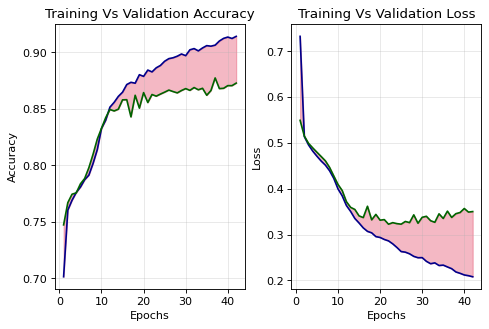

In [36]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy')
ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss')
ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

## Saving the model

Saving the tokenizer

In [37]:
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as json_file:
    json_file.write(tokenizer_json)

In [44]:
json_object = json.dumps(tags2id, indent = 4)
print(json_object)
with open("tags2id.json", "w") as json_file:
    json_file.write(json_object)

{
    "FOOD": 0,
    "O": 1,
    "QUANTITY": 2,
    "UNIT": 3
}


In [45]:
json_object = json.dumps(id2tag, indent = 4)
print(json_object)
with open("id2tag.json", "w") as json_file:
    json_file.write(json_object)

{
    "0": "FOOD",
    "1": "O",
    "2": "QUANTITY",
    "3": "UNIT"
}


Saving and converting the model to TFLite

In [ ]:
model.save("./NER")

In [43]:
converter = tf.lite.TFLiteConverter.from_saved_model('./NER')
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS,  # enable TensorFlow ops.
    #tf.lite.Optimize.DEFAULT
]
tflite_model = converter.convert()

with open('NER.tflite', 'wb') as f:
    f.write(tflite_model)